In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clustering

In [2]:
customer_indicators = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

### Pre-processing

In [3]:
dataset = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
dataset['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
dataset['Recency'] = customer_indicators[['Recency']]
dataset['CustomerID'] = customer_indicators[['CustomerID']]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset[['Delta', 'Recency', 'RMonetary']].values)

## K-means

In [4]:
sse = []
silhouette = []
kmax = 19
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(data_scaled, kmeans.labels_))

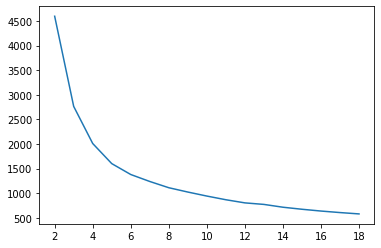

In [5]:
# Elbow curve.
ax = plt.plot(range(2, kmax), sse)
plt.show()

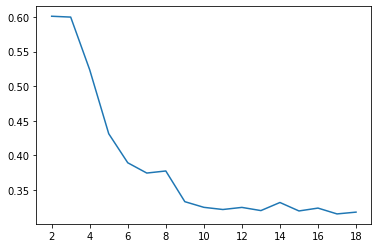

In [6]:
# Silhouette score.
ax = plt.plot(range(2, kmax), silhouette)
plt.show()

SSE: 
1379.0043977876214
Silhouette: 
0.38957803883430603


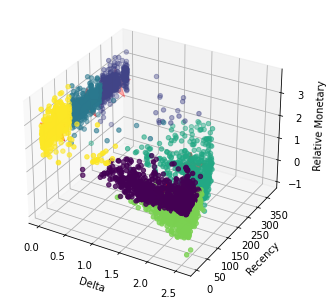

array([0, 4, 5, ..., 4, 4, 0], dtype=int32)

In [7]:
# kmeans best choice parameters

k_best = 6
kmeans_best = KMeans(n_clusters=k_best, n_init=10, max_iter=100)
kmeans_best.fit(data_scaled)
print('SSE: ') 
print(kmeans_best.inertia_)
print('Silhouette: ') 
print(silhouette_score(data_scaled, kmeans_best.labels_))

centers = scaler.inverse_transform(kmeans_best.cluster_centers_)
centroids_x = centers[:,0]
centroids_y = centers[:,1]
centroids_z = centers[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=kmeans_best.labels_)
ax.scatter(centroids_x,centroids_y,centroids_z,s=1000, marker='*', c='r')
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative Monetary')
plt.show()

### Post-processing

In [8]:
# create column containing cluster label
dataset['Behavior'] = kmeans_best.labels_
dataset.head()

,RMonetary,Delta,Recency,CustomerID,Behavior
0,1.071,2.563,2,12347,0
1,0.706,2.452,75,12348,4
2,3.164,0.000,19,12349,5
3,2.469,0.000,310,12350,1
4,0.725,2.417,36,12352,4


In [9]:
sns.pairplot(data=dataset, hue="Behavior", palette="Accent")
plt.show()


KeyboardInterrupt



In [ ]:
clusters = list()
for i in range(0, 6):
    clusters.append(dataset[dataset['Behavior'] == i])

In [ ]:
for i in range(0, len(clusters)):
    print(clusters[i].describe())

## DBSCAN

In [ ]:
dist = pdist(data_scaled, 'euclidean')
dist = squareform(dist)

In [ ]:
plt.ylabel('dist from k-th neighbor')
plt.xlabel('sorted distances')
plt.tick_params(axis='both')
for k in range(5, 10):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))

In [ ]:
# Random parameters selection
density = DBSCAN(eps=0.2, min_samples=5).fit(data_scaled)
labels = density.labels_
labels

In [ ]:
dbscan_df = dataset.copy()
del dbscan_df['Behavior']
dbscan_df["label"] = labels

In [ ]:
sns.pairplot(data = dbscan_df, hue = "label", palette = "Accent")
plt.show()

## Grid search

In [ ]:
eps_to_test = [round(eps, 1) for eps in np.arange(0.1, 1, 0.1)]
min_samples_to_test = range(5, 50, 5)

In [ ]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting
    dbscan_model_ = DBSCAN(eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log
    #print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [ ]:
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [ ]:
iter_ = 0

#print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
#print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Computing metrics
        noise_metric, cluster_metric = get_metrics(eps, min_samples, data_scaled, iter_)
        
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [ ]:
# Best parameters
density = DBSCAN(eps=0.4, min_samples=5).fit(data_scaled)
labels = density.labels_
print(metrics.silhouette_score(data_scaled, labels))

results = np.unique(labels, return_counts=True)
print(f"Clusters labels: {results[0]}")
print(f"Elements per cluster: {results[1]}")

In [ ]:
dbscan_df["label"] = labels
sns.pairplot(data=dbscan_df, hue="label", palette="Accent")
plt.show()

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=density.labels_)
ax.set_xlabel('D')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

# Hierarchical

In [ ]:
dataset = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
dataset['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
dataset['Recency'] = customer_indicators[['Recency']]#.apply(np.log10, axis=1).round(3)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset[['Delta', 'Recency', 'RMonetary']].values)

dataframe_scaled = pd.DataFrame(data_scaled, columns=dataset.columns)

In [ ]:
threshold = 50
data_dist = pdist(data_scaled, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')
print(metrics.silhouette_score(dataframe_scaled, clusters))

In [ ]:
threshold = 0.6
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')
print(metrics.silhouette_score(dataframe_scaled, clusters))

In [ ]:
threshold = 4
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')
print(metrics.silhouette_score(dataframe_scaled, clusters))

In [ ]:
threshold = 1.7
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')
print(metrics.silhouette_score(dataframe_scaled, clusters))

In [ ]:
agg_ward = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
agg_ward.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['RMonetary'], dataframe_scaled['Delta'], c=agg_ward.labels_) 

In [ ]:
agg_single = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')  
agg_single.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['RMonetary'], dataframe_scaled['Delta'], c=agg_single.labels_) 

In [ ]:
agg_comp = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')  
agg_comp.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['RMonetary'], dataframe_scaled['Delta'], c=agg_comp.labels_) 

In [ ]:
agg_avg = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')  
agg_avg.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['RMonetary'], dataframe_scaled['Delta'], c=agg_avg.labels_) 

## Comparisons

In [ ]:
labels_kmeans = kmeans.labels_
labels_comp = agg_comp.labels_
labels_avg = agg_avg.labels_
labels_ward = agg_ward.labels_
labels_single = agg_single.labels_

kmean_sil = metrics.silhouette_score(dataframe_scaled, labels_kmeans)
ward_sil = metrics.silhouette_score(dataframe_scaled, labels_ward) 
avg_sil = metrics.silhouette_score(dataframe_scaled,labels_avg)  
comp_sil = metrics.silhouette_score(dataframe_scaled, labels_comp)
single_sil = metrics.silhouette_score(dataframe_scaled, labels_single)

print(kmean_sil)
print(ward_sil)
print(avg_sil)
print(comp_sil)
print(single_sil)

# Extra: X-Means

In [ ]:
from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES;

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer;

from pyclustering.cluster import cluster_visualizer;
from pyclustering.cluster.xmeans import xmeans, splitting_type;

In [ ]:
# initial centers - optional parameter, if it is None, then random centers will be used by the algorithm.
# avoid random initial centers and initialize them using K-Means++ method

initial_centers = kmeans_plusplus_initializer(data_scaled, 2).initialize();
xmeans_instance = xmeans(data_scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);

### Bayesian Information Criterion

In [ ]:
initial_centers = kmeans_plusplus_initializer(data_scaled, 2).initialize();
xmeans_instance = xmeans(data_scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);

# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters();
centers = xmeans_instance.get_centers()

# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, data_scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

### Minimum Noiseless Description Length

In [ ]:
initial_centers = kmeans_plusplus_initializer(data_scaled, 2).initialize();
xmeans_instance = xmeans(data_scaled, initial_centers, criterion=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH, ccore=True);
# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, data_scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

# SOM-SC

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.somsc import somsc
from pyclustering.samples.definitions import FCPS_SAMPLES

# Create instance of SOM-SC algorithm to allocated six clusters
somsc_instance = somsc(data_scaled, 6)

# Run cluster analysis and obtain results
somsc_instance.process()
clusters = somsc_instance.get_clusters()

# Visualize clustering results.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, data_scaled)
visualizer.show()

# Preparation for classification

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=kmeans.labels_)
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

The customers with delta = 0 (the delta axis is log-transformed) have observations for only one day, so we can't derive an effective classification among high, medium or low spending, and we remove them for the next task.

In [ ]:
low = dataset[(dataset['Delta'] == 0) & (dataset['Recency'] > 60)]
dataset = dataset[dataset['Delta'] != 0]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset[['Delta', 'Recency', 'RMonetary']].values)

In [ ]:
sse = []
silhouette = []
kmax = 6
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(data_scaled, kmeans.labels_))
dataset['Behavior'] = kmeans.labels_

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=kmeans.labels_)
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')

ax.set_xlim3d(0, 3)
ax.set_ylim3d(0, 400)
ax.set_zlim3d(-1, 4)

plt.show()

In [ ]:
x = dataset[dataset['Behavior'] == 4]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x['Delta'], x['Recency'], x['RMonetary'])
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')

ax.set_xlim3d(0, 3)
ax.set_ylim3d(0, 400)
ax.set_zlim3d(-1, 4)

plt.show()

In [ ]:
def Score(x):
    if x == 1:
        return 'High'
    elif x == 3:
        return 'Low'
    else:
        return 'Medium'

In [ ]:
dataset['Label'] = dataset['Behavior'].apply(Score)
del dataset['Behavior']
dataset.head()

In [ ]:
low['Label'] = 'Low'

In [ ]:
result = dataset.append(low)

In [ ]:
#result.to_csv('datasets/clustering_labels.csv')